# Polarsによる時系列データの取り扱い
面倒な時系列データをPolarsで取り扱う方法をメモしておく。  

In [124]:
import polars as pl
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import os
import math
import pyarrow as pa
import pyarrow.parquet as pq
import itertools
from pathlib import Path
from glob import glob
from sklearn.preprocessing import StandardScaler, LabelEncoder

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## 様々な形式で表現された時刻データの読み込み方
ログの分析などではナノ秒まで情報が必要な場合があるので、  
適宜ナノ秒まで含めて取り扱う。  
年月日がいらないケースでも基本的にdatetimeに変換しておくと便利。

### - 時刻データが綺麗にフォーマットされている場合

In [104]:
df = pl.DataFrame({'Time': 
         ['2020-01-01 00:00:00.123456789',
          '2020-01-01 00:00:00.123456790',
          '2020-01-01 00:00:00.123456791']
        })

In [105]:
# カラムの横幅を40文字まで拡張して表示
pl.Config.set_fmt_str_lengths(40)
df

Time
str
"""2020-01-01 00:00:00.123456789"""
"""2020-01-01 00:00:00.123456790"""
"""2020-01-01 00:00:00.123456791"""


pl.DataFrameのschemaにpl.Datetime("ns")を指定するのはダメそうだったので、  
strで一旦読み込む。  
カラムの幅が狭くてナノ秒まで見えないときはpl.Config.set_fmt_str_lengths(文字数)  で調整するとよい。  
https://pola-rs.github.io/polars/py-polars/html/reference/api/polars.Config.set_fmt_str_lengths.html

In [106]:
df.get_column('Time').str.strptime(pl.Datetime("ns"))

Time
datetime[ns]
2020-01-01 00:00:00.123456789
2020-01-01 00:00:00.123456790
2020-01-01 00:00:00.123456791


ナノ秒まで含めてDatetime型に変換するには上記のように書けばよい。  
この場合はstrptimeに特にフォーマットを指定する必要はない。  
https://stackoverflow.com/questions/75119895/parse-nanoseconds-with-polars

### - 数字の羅列になっている場合

In [135]:
df = pl.DataFrame({'Time': 
         ['20200101000000123456789',
          '20200101000000123456790',
          '20200101000000123456791']
        })

In [136]:
df

Time
str
"""20200101000000123456789"""
"""20200101000000123456790"""
"""20200101000000123456791"""


In [139]:
# ナノ秒まで含めてDatetime型に変換
df.get_column('Time').str.strptime(pl.Datetime('ns'), '%Y%m%d%H%M%S%f')

Time
datetime[ns]
2020-01-01 00:00:00.123456789
2020-01-01 00:00:00.123456790
2020-01-01 00:00:00.123456791


上記のように書くことで、数字の羅列もDatetime型へ変換可能。  
フォーマットの指定には'-'や':'は不要っぽい。  
pl.Datetime('ms')などにすることで秒以下の単位を変更できる。

In [110]:
df_2.get_column('Time').str.strptime(pl.Datetime('ns'), '%Y%m%d%H%M%S%f').diff()

Time
duration[ns]
null
1ns
1ns


.diff()でひとつ前のレコードとの時刻差を算出できる。

### - 年月日と時刻が別のカラムの場合

In [111]:
df = pl.DataFrame({
    'Date':['20200101',
            '20200102',
            '20200103'],
    'Time': ['131205123456789',
             '133406123456790',
             '142215123456791']
        })

In [112]:
df

Date,Time
str,str
"""20200101""","""131205123456789"""
"""20200102""","""133406123456790"""
"""20200103""","""142215123456791"""


In [113]:
df.select(
    (pl.col('Date') + pl.col('Time')).str
    .strptime(pl.Datetime('ns'), '%Y%m%d%H%M%S%f').alias('Date_and_Time')
)

Date_and_Time
datetime[ns]
2020-01-01 13:12:05.123456789
2020-01-02 13:34:06.123456790
2020-01-03 14:22:15.123456791


上記のようにどちらも文字列として読み込み、結合してからstrptimeでdatetime型に変換する。

### - さらにカラムが分けられているケース

In [114]:
# sampleデータ読み込み。年月日、時分秒、ms以下はそれぞれ別カラムにしている。
dtypes = {
    'ymd': str,
    'hms': str,
    'ms_us_ns': str,
    'value': float
}
df = pl.read_csv('../sample_data/time_series/time_series_data_sample_1.csv', dtypes=dtypes)
df.head()

ymd,hms,ms_us_ns,value
str,str,str,f64
"""2020/1/1""","""00:00:00""","""000000000""",0.993612
"""2020/1/1""","""00:00:00""","""000100000""",0.248432
"""2020/1/1""","""00:00:00""","""000200000""",0.252184
"""2020/1/1""","""00:00:00""","""000300000""",0.597972
"""2020/1/1""","""00:00:00""","""000400000""",0.497804


dfに読み込む前にcsvにどのように記録されているか確認し、必要に応じてデータ型を指定して読み込むこと。  
上記ではms_us_nsが数字の羅列になっているので、dtypesを指定しないとintになってしまい、先頭の0が抜けてしまう。  
また、excelでCSVファイルを開くと勝手に型を置き換えたりして元々のcsvの情報が欠落するので、必ずテキストエディタで開くこと。

In [119]:
# 基本的に2020-01-01 00:00:00.123456789のような形になるようにスペース、ドットを足せば変換できる。
df.with_columns(
    (pl.col('ymd') +' ' + pl.col('hms') + '.' + pl.col('ms_us_ns')).str
    .strptime(pl.Datetime('ns')).alias('date_time')
).head()

ymd,hms,ms_us_ns,value,date_time
str,str,str,f64,datetime[ns]
"""2020/1/1""","""00:00:00""","""000000000""",0.993612,2020-01-01 00:00:00
"""2020/1/1""","""00:00:00""","""000100000""",0.248432,2020-01-01 00:00:00.000100
"""2020/1/1""","""00:00:00""","""000200000""",0.252184,2020-01-01 00:00:00.000200
"""2020/1/1""","""00:00:00""","""000300000""",0.597972,2020-01-01 00:00:00.000300
"""2020/1/1""","""00:00:00""","""000400000""",0.497804,2020-01-01 00:00:00.000400


## 任意の時間範囲でフィルタリング
参考：https://pola-rs.github.io/polars-book/user-guide/transformations/time-series/filter/

In [22]:
df = pl.DataFrame({'date': 
         ['2020-01-01 00:00:00.123456789',
          '2020-01-01 00:00:00.123456790',
          '2020-01-01 00:00:00.123456791',
          '2020-01-01 00:00:00.999999999',
          '2020-01-01 00:00:01.100000001',
          '2020-01-01 00:00:02.100000002',
          '2020-01-01 00:00:03.100000003',
          '2020-01-01 00:00:10.390938889',
          '2020-01-01 00:01:10.111233999',
          '2020-01-01 00:10:10.111233999',
          '2020-01-01 00:10:10.111233999']
        })

df = df.with_columns(
    pl.col('date').str.strptime(pl.Datetime("ms"))
)
df.head()

date
datetime[ms]
2020-01-01 00:00:00.123
2020-01-01 00:00:00.123
2020-01-01 00:00:00.123
2020-01-01 00:00:00.999
2020-01-01 00:00:01.100


In [23]:
# 時間のフィルタリング範囲を設定。ナノ秒までは対応していない模様。
start_time = datetime.datetime(year=2020, month=1, day=1, hour=0, minute=0, second=0, microsecond=1)
end_time = datetime.datetime(year=2020, month=1, day=1, hour=0, minute=0, second=1, microsecond=100000)

In [24]:
df.filter(
    pl.col('date').is_between(start_time, end_time)
)

date
datetime[ms]
2020-01-01 00:00:00.123
2020-01-01 00:00:00.123
2020-01-01 00:00:00.123
2020-01-01 00:00:00.999
2020-01-01 00:00:01.100


In [28]:
df.dtypes

[Datetime(time_unit='ms', time_zone=None)]

In [37]:
df

date
datetime[ms]
2020-01-01 00:00:00.123
2020-01-01 00:00:00.123
2020-01-01 00:00:00.123
2020-01-01 00:00:00.999
2020-01-01 00:00:01.100
2020-01-01 00:00:02.100
2020-01-01 00:00:03.100
2020-01-01 00:00:10.390
2020-01-01 00:01:10.111


is_betweenに開始時刻、終了時刻をdatetime.datetimeで指定することでフィルタリングできる。  
ナノ秒は対応していないようだが、実用上はマイクロ秒までで十分だと思われる。  
ナノ秒レベルでフィルタリングしたい場合はms以下の９桁だけ数値で扱うのが良いかも。

## 時刻をx軸としてグラフを描いて軸範囲を操作する

In [121]:
# sampleデータ読み込み。年月日、時分秒、ms以下はそれぞれ別カラムにしている。
dtypes = {
    'ymd': str,
    'hms': str,
    'ms_us_ns': str,
    'value': float
}
df = pl.read_csv('../sample_data/time_series/time_series_data_sample_1.csv', dtypes=dtypes)
df = df.with_columns(
    (pl.col('ymd') +' ' + pl.col('hms') + '.' + pl.col('ms_us_ns')).str
    .strptime(pl.Datetime('ns')).alias('date_time')
).select(
    # 元々のymd,hms等は不要なので落とす。
    ['date_time', 'value']
)

In [122]:
df.head()

date_time,value
datetime[ns],f64
2020-01-01 00:00:00,0.993612
2020-01-01 00:00:00.000100,0.248432
2020-01-01 00:00:00.000200,0.252184
2020-01-01 00:00:00.000300,0.597972
2020-01-01 00:00:00.000400,0.497804


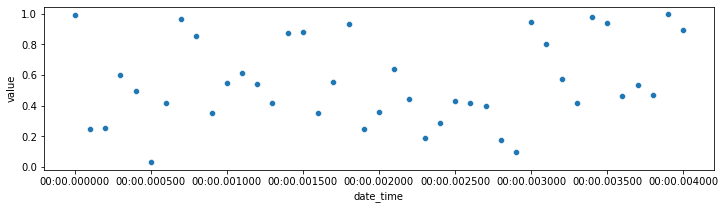

In [125]:
fix, ax = plt.subplots(figsize=(12, 3))
sns.scatterplot(x='date_time', y='value', data=df)

# 軸目盛をμ秒単位で調整するためのlocaterオブジェクトを生成
locater = mdates.MicrosecondLocator(interval=500)
ax.xaxis.set_major_locator(locater)

In [129]:
# 時間のフィルタリング範囲を設定。最初の1000μ秒だけに絞る
start_time = datetime.datetime(year=2020, month=1, day=1, hour=0, minute=0, second=0, microsecond=0)
end_time = datetime.datetime(year=2020, month=1, day=1, hour=0, minute=0, second=0, microsecond=1000)

(18262.0, 18262.000000011572)

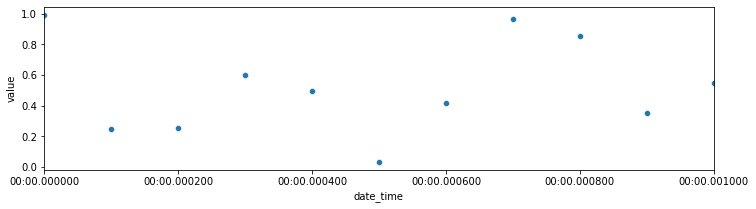

In [131]:
fix, ax = plt.subplots(figsize=(12, 3))
sns.scatterplot(x='date_time', y='value', data=df)

# set_xlimに開始時刻と終了時刻をdatetime型で入れればOK
ax.set_xlim(start_time, end_time)
